Author: Harshal Bhasgauri

importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler


In [5]:
df = pd.read_csv('CreditCardDataset.csv')

##1) Perform EDA

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
1,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
2,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
3,11,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0
4,12,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,...,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,15.99,0


the dataset has 31 columns including the target variable, Class. The target variable Class takes the value 1 in case of fraud and 0 otherwise.

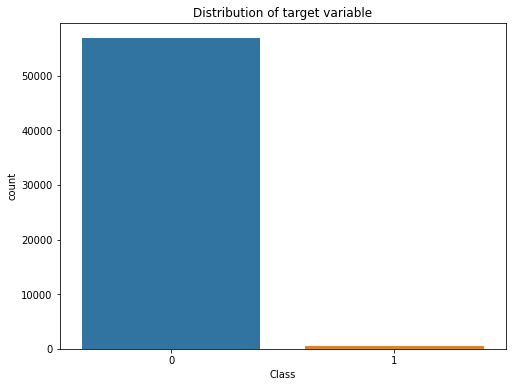

In [11]:
#checking distribution of 'Class'
plt.figure(figsize=(8,6))
sns.countplot(x='Class', data=df)
plt.title('Distribution of target variable')
plt.show()

I can see that the dataset is heavily imbalanced, with a very small number of fraud cases compared to non-fraud cases. 

Using undersampling to handle heavy imbalance

In [8]:
fraud_indices = df[df.Class == 1].index
non_fraud_indices = df[df.Class == 0].index

random_non_fraud_indices = np.random.choice(non_fraud_indices, len(fraud_indices), replace=False)

undersampled_indices = np.concatenate([fraud_indices, random_non_fraud_indices])
undersampled_df = df.loc[undersampled_indices]

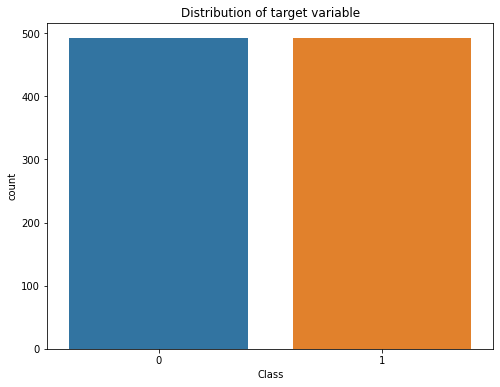

In [12]:
#checking distribution of 'Class' again
plt.figure(figsize=(8,6))
sns.countplot(x='Class', data=undersampled_df)
plt.title('Distribution of target variable')
plt.show()

class distribution is handled.

##2) implementing a neural network using the PyTorch framework.
>creating a DataLoader object to load the data into the model.

In [13]:
# Splitting the data into training and testing sets
X = undersampled_df.drop('Class', axis=1).values
y = undersampled_df['Class'].values
# Standardizing the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Converting the data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
# Creating a TensorDataset
dataset = TensorDataset(X, y)
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
# Creating a DataLoader for training and validation sets
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


> defining our neural network architecture. Here I am using a simple feedforward neural network with two hidden layer.

In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(30, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

model = Net()

>defining the loss function and optimizer for my model.

In [15]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

>defining a function that takes in my model, data loaders, loss function, and optimizer, and trains the model for a specified number of epochs.

In [18]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_correct = 0
        val_correct = 0

        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            train_pred = torch.round(output)
            train_correct += (train_pred == target.view(-1, 1)).sum().item()

        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = criterion(output, target.view(-1, 1))
                val_loss += loss.item() * data.size(0)
                val_pred = torch.round(output)
                val_correct += (val_pred == target.view(-1, 1)).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_acc, val_loss, val_acc))

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

Epoch: 1 	Training Loss: 0.675079 	Training Accuracy: 0.580686 	Validation Loss: 0.609563 	Validation Accuracy: 0.903553
Epoch: 2 	Training Loss: 0.583117 	Training Accuracy: 0.836086 	Validation Loss: 0.528534 	Validation Accuracy: 0.913706
Epoch: 3 	Training Loss: 0.508625 	Training Accuracy: 0.865311 	Validation Loss: 0.441584 	Validation Accuracy: 0.918782
Epoch: 4 	Training Loss: 0.422886 	Training Accuracy: 0.886912 	Validation Loss: 0.360928 	Validation Accuracy: 0.918782
Epoch: 5 	Training Loss: 0.356966 	Training Accuracy: 0.898348 	Validation Loss: 0.296719 	Validation Accuracy: 0.918782
Epoch: 6 	Training Loss: 0.312909 	Training Accuracy: 0.893266 	Validation Loss: 0.253979 	Validation Accuracy: 0.928934
Epoch: 7 	Training Loss: 0.273724 	Training Accuracy: 0.908513 	Validation Loss: 0.224697 	Validation Accuracy: 0.923858
Epoch: 8 	Training Loss: 0.257007 	Training Accuracy: 0.900889 	Validation Loss: 0.204609 	Validation Accuracy: 0.939086
Epoch: 9 	Training Loss: 0.23317

>I have added two additional lists to track the training and validation accuracy over the training process. I have also modified the training loop to calculate the number of correct predictions and use it to calculate the accuracy of the model on each epoch.

>A) plotting the training and validation loss

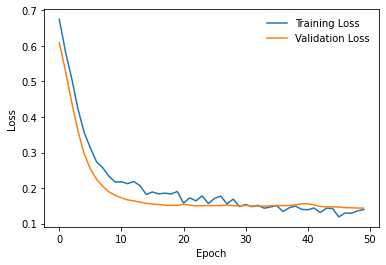

In [20]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

here, I can see that the training loss and validation loss decrease over the course of the training process, indicating that the model is learning to classify credit card transactions as fraudulent or not. The training and validation loss are similar, indicating that the model is not overfitting to the training data.

>B) plotting the training and validation accuracy

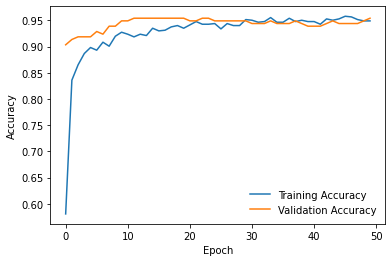

In [19]:
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

 >>the training and validation accuracy both increase over the course of the training process, indicating that the model is learning to classify credit card transactions as fraudulent or not with increasing accuracy. The training and validation accuracy are similar, indicating that the model is not overfitting to the training data.

##3) Conclusion

Based on the plotted training and validation loss and accuracy, we can see that the model is learning and improving during training, with the both the loss and accuracy improving over time. The validation loss and accuracy also show that the model is not overfitting to the training data, as they are improving along with the training metrics. This suggests that the model is generalizing well to unseen data. However, we should also note that there is still some room for improvement, as the validation accuracy has not yet stabilisied and could potentially improve with further training or hyperparameter tuning.


References:

1.   https://pytorch.org/docs/stable/index.htmlst
2.   https://pytorch.org/tutorials/
3.   https://towardsdatascience.com/building-neural-network-using-pytorch-84f6e75f9a

